# Autocorrelation Metric

## A toy problem

In [5]:
import numpy as np

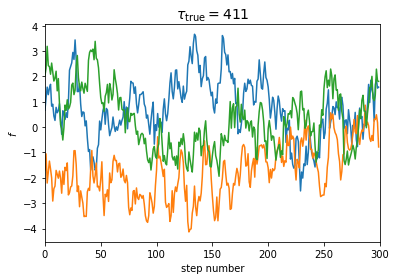

In [28]:
import matplotlib.pyplot as plt

np.random.seed(1234)

# Build the celerite model:
import celerite
from celerite import terms

kernel = terms.RealTerm(log_a=0.0, log_c=-6.0)
kernel += terms.RealTerm(log_a=0.0, log_c=-2.0)

# The true autocorrelation time can be calculated analytically:
true_tau = sum(2 * np.exp(t.log_a - t.log_c) for t in kernel.terms)
true_tau /= sum(np.exp(t.log_a) for t in kernel.terms)
true_tau

# Simulate a set of chains:
gp = celerite.GP(kernel)
t = np.arange(2000000)
gp.compute(t)
y = gp.sample(size=32)

# Let's plot a little segment with a few samples:
plt.plot(y[:3, :300].T)
plt.xlim(0, 300)
plt.xlabel("step number")
plt.ylabel("$f$")
plt.title("$\\tau_\mathrm{{true}} = {0:.0f}$".format(true_tau), fontsize=14);

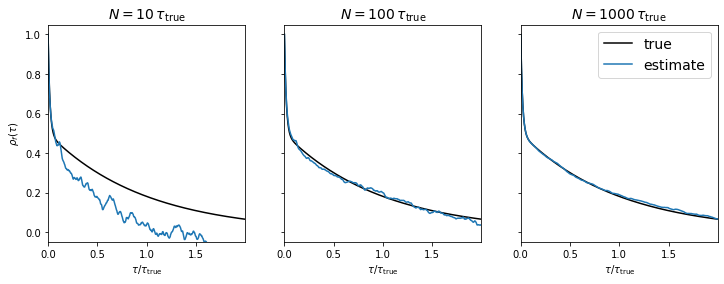

In [29]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf


# Make plots of ACF estimate for a few different chain lengths
window = int(2 * true_tau)
tau = np.arange(window + 1)
f0 = kernel.get_value(tau) / kernel.get_value(0.0)

# Loop over chain lengths:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    ax.plot(tau / true_tau, autocorr_func_1d(y[0, :nn])[: window + 1], label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

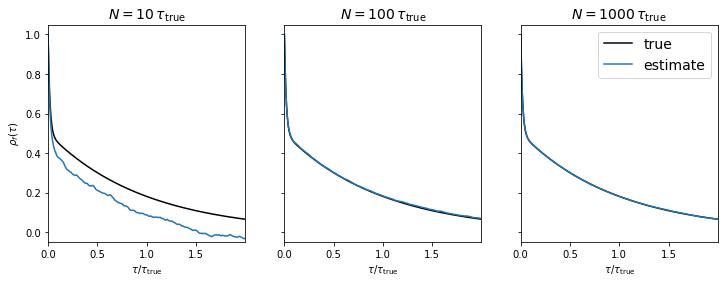

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    f = np.mean(
        [autocorr_func_1d(y[i, :nn], norm=False)[: window + 1] for i in range(len(y))],
        axis=0,
    )
    f /= f[0]
    ax.plot(tau / true_tau, f, label="estimate")
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

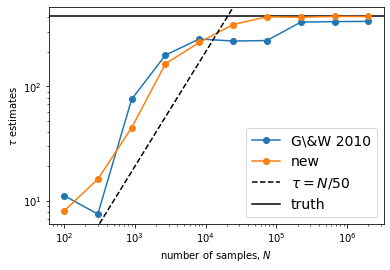

In [32]:
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

## GQPMC Data

In [104]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters
import seaborn as sns

specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:]

class convergence_plotter_single():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}')]  
        f.sort()
        print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
    
    def walker_perc_plot(self,gal_idx,spec_photo,step=1000, flag = "", cl = False):
        import seaborn as sns
        data = self.files[0]['mcmc_chain'][...][:,0]
        num_gal = len(data)
        
        plt.figure(figsize=(12,9))
        plt.xlabel('$N_{iteration}$')
        plt.ylabel('Median')
        plt.grid()
        plt.title(f'{spec_photo} igal{gal_idx} walker_percentile plot {flag}')
        colors = plt.cm.copper(np.linspace(0,1,self.num_walkers))
        ys = []
        for i in range(self.num_walkers):
            y, up_perc, lo_perc = [], [], []
            length = len(data)//self.num_walkers
            inc = length//step
            x_axis = (np.arange(inc)+1) * step
              
            for n in range(inc):
                walker_sample = data[i:step * (1+n):self.num_walkers]
                up = np.percentile(walker_sample,84.1)
                lo = np.percentile(walker_sample,15.9)
                med = np.median(walker_sample)
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            if np.all(y == y[0]):
                color = 'firebrick'
            else:
                color = 'steelblue'
  
            
            yerr = np.vstack((up_perc,lo_perc))
            plt.plot(x_axis,y,lw = 1, c = color)#colors[i]
            ys.append(y)
            plt.fill_between(x_axis, np.array(y)-np.array(lo_perc), np.array(y)+np.array(up_perc), color = 'steelblue', alpha = 0.025)
        plt.axhline(input_mass[gal_idx], c = 'r', lw = 1)
#         plt.show()
        
        num_stat = 0
        for y in ys:
            if np.all(y == y[0]):
                num_stat += 1
        
        return num_stat
    
    def avg_perc_plot(self,ax, gal_idx, spec_photo,step=1000, flag = ''):
        data = self.files[0]['mcmc_chain'][...][:,0]
        perc_err = []
        
        y,up_perc,lo_perc = [], [], []
        length = len(data)
        inc = length//step
        x_axis = (np.arange(inc)+1)*step
        for n in range(inc):
            up = np.percentile(data[:step*(1+n)],84.1)
            lo = np.percentile(data[:step*(1+n)],15.9)
            med = np.median(data[:step*(1+n)])
            up_perc.append(up-med)
            lo_perc.append(med-lo)
            y.append(med)

        yerr = np.vstack((up_perc,lo_perc))    
        ax.set_xlabel('$N_{iteration}$')
        ax.set_ylabel('Median')
        ax.grid()
#         ax.set_title(f'{spec_photo} igal{gal_idx} percentile plot {flag}')
        ax.axhline(input_mass[gal_idx], lw = 1, c = 'r')
        ax.text(length,y[-1],f'{y[-1]}')
        ax.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
#         plt.xlim(-10000,None)
#         plt.savefig(f'Percentile plot galaxy {idx+1}.pdf', format = 'pdf')
#         plt.show()
#         perc_err.append(100*(y[-1]-input_mass[idx])/input_mass[idx])
#         return perc_err
    

    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:

            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF


    def PSRF_plot(self,spec_photo,step=1000, flag = ''):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot {flag}')
            

test_gal = convergence_plotter_single(40,50000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/iSpeculator_validation/specphoto_0_96/lgal.specphoto.noise_bgs0_legacy.emulator.0.mcmc.hdf5')
test_gal.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/iSpeculator_validation/specphoto_0_96/lgal.specphoto.noise_bgs0_legacy.emulator.0.mcmc.hdf5']


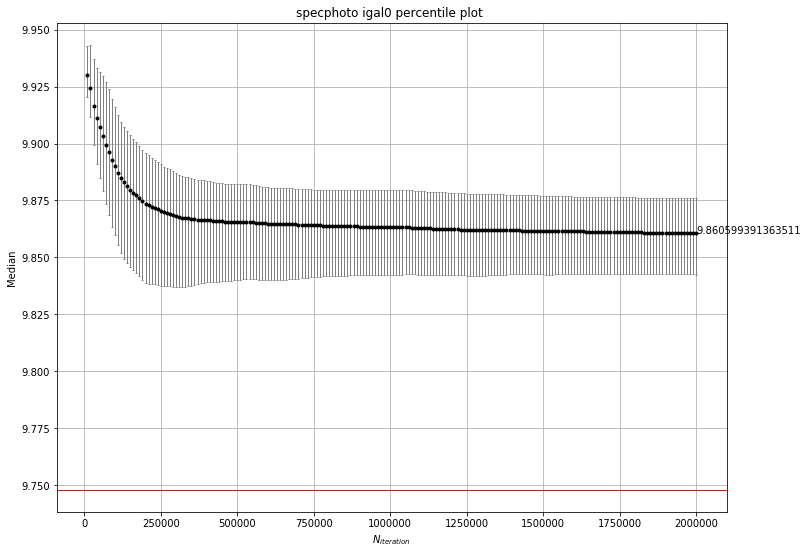

In [58]:
test_gal.avg_perc_plot(0,'specphoto',step = 10000)

In [34]:
gqpmc_path = os.environ.get('GQPMC_DIR')
print(gqpmc_path)

/Users/jameskwon/Documents/Research/Data/gqp_mc/


In [60]:
gqp_chain = h5py.File(gqpmc_path+'mini_mocha/ispeculator/iSpeculator_validation/specphoto_0_96/lgal.specphoto.noise_bgs0_legacy.emulator.0.mcmc.hdf5', 'r')

In [61]:
def printname(name):
    print(name)
    return None

In [63]:
data = gqp_chain['mcmc_chain'][...][:,0]
num_walkers = 40

data_r = []
for i in range(num_walkers):
    print(i, end = '\r')
    data_r.append(data[i::num_walkers])
data_r = np.array(data_r)

In [64]:
print(np.array(data_r).shape)

(40, 50000)


In [65]:
print(np.array(data_r).shape)
data = data_r

(40, 50000)


In [66]:
meds = []
step = 500
for a,row in enumerate(data):
    print(a, end = '\r')
    for idx in range(len(row)//step):
        meds.append(np.median(row[:step*(idx+1):step]))

In [67]:
length = data.shape[1]
N = np.arange(1000,length,1000)

In [68]:
gw2010 = np.empty(len(N))
new = np.empty(len(N))

for i, n in enumerate(N):
    print(i, end = '\r')
    gw2010[i] = autocorr_gw2010(data_r[:,:n])
    new[i] = autocorr_new(data_r[:,:n])

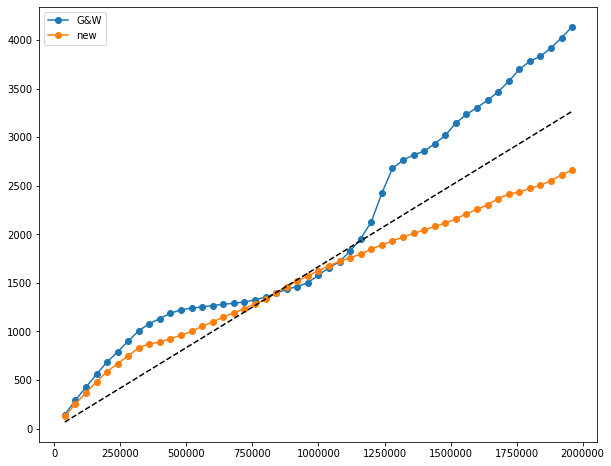

In [86]:
# plt.loglog(N,gw2010,'o-', label = 'G&W')
# plt.loglog(N,new, 'o-', label = 'new')
plt.figure(figsize=(10,8))
plt.plot(N*40,gw2010,'o-', label = 'G&W')
plt.plot(N*40,new, 'o-', label = 'new')
plt.plot(N*40,N/15, ls = '--', color = 'k')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')


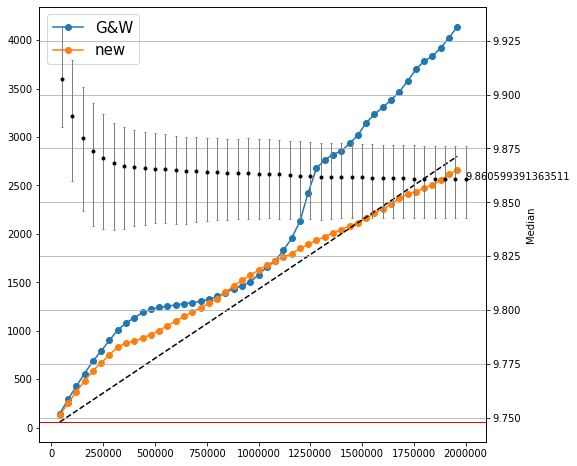

In [117]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax2 = ax.twinx()
test_gal.avg_perc_plot(ax2,0,'specphoto',step = 50000)
ax.plot(N*40,gw2010,'o-', label = 'G&W')
ax.plot(N*40,new, 'o-', label = 'new')
ax.plot(N*40,N*40/700, ls = '--', color = 'k')
ax.legend(fontsize = 15)